# 5.6. Dropout

Outra noção útil de simplicidade é a suavidade, ou seja, que a função não deve ser sensível a pequenas alterações nas suas entradas. Por exemplo, quando classificamos imagens, esperaríamos que adicionar algum ruído aleatório aos pixels fosse praticamente inofensivo.

__Dropout__ envolve a injeção de ruído durante o cálculo de cada camada interna durante a propagação direta e se tornou uma técnica padrão para treinamento de redes neurais. O método é chamado de abandono porque literalmente eliminamos alguns neurônios durante o treinamento. Ao longo do treinamento, em cada iteração, o dropout padrão consiste em zerar alguma fração dos nós em cada camada antes de calcular a camada subsequente.

Os autores argumentam que o overfitting da rede neural é caracterizado por um estado em que cada camada depende de um padrão específico de ativações na camada anterior, chamando essa condição de co-adaptação . O abandono escolar, afirmam eles, desfaz a co-adaptação, tal como se argumenta que a reprodução sexual desfaz os genes co-adaptados. Embora tal justificação desta teoria esteja certamente em debate, a própria técnica de abandono provou ser duradoura, e várias formas de abandono são implementadas na maioria das bibliotecas de aprendizagem profunda.

O principal desafio é como injetar esse ruído. Uma ideia é injetá-lo de maneira imparcial para que o valor esperado de cada camada - enquanto fixa as outras - seja igual ao valor que teria obtido na ausência do ruído. No trabalho de Bishop, ele adicionou ruído gaussiano às entradas de um modelo linear. 

Standard dropout regularization:

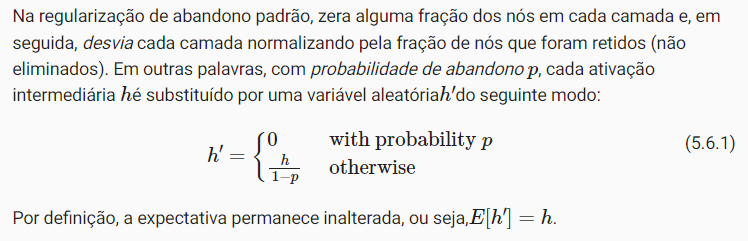

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 5.6.1. Dropout in Practice

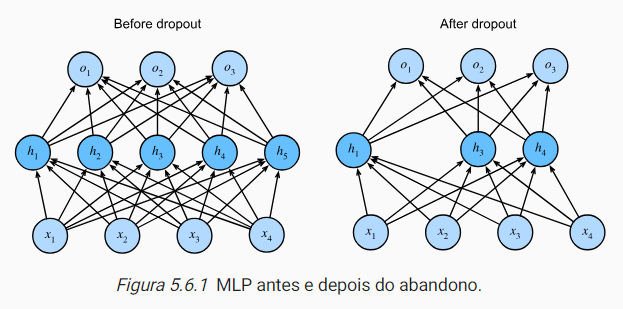

As unidades (ou neurônios, ou nós) h2 e h5 estão removidos. Consequentemente, o cálculo dos resultados já não depende de h2 e h5 e seu respectivo gradiente também desaparece ao realizar a retropropagação. Desta forma, o cálculo da camada de saída não pode ser excessivamente dependente de qualquer elemento de h1 a h5.

__Normalmente, desabilitamos o abandono no momento do teste. Dado um modelo treinado e um novo exemplo, não eliminamos nenhum nó e, portanto, não precisamos normalizar.__ No entanto, existem algumas exceções: alguns pesquisadores usam o abandono no momento do teste como uma heurística para estimar a incerteza das previsões da rede neural: se as previsões concordarem em muitos resultados de abandono diferentes, então poderemos dizer que a rede é mais confiante.


# 5.6.2. Implementação do zero

- p é a probabilidade de abondono

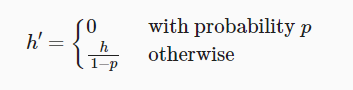

- Se p = 1, ou seja, 100% de probabilidade de abandono, todas as unidades h serão zeradas.
- Se p for diferente de 1, as unidades h serão substituídas por h' que é igual a h/(1-p). Desta forma, quando p=0, as unidades h permanecem inalteradas.

In [5]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)      # Se p = 1, ou seja, 100% de probabilidade de abandono, todas as unidades h serão zeradas.
    mask = (torch.rand(X.shape) > dropout).float()   # mask aplica distribuição uniform (torch.rand()) aleatória para determinar quais unidades serão zerdas. 
                                                     # Mantém apenas os nós para os quais a amostra correspondente é maior que p.

    return mask * X / (1.0 - dropout)                # As unidades não zerdas serão alteradas desta forma h' = h/(1-p).

Podemos testar a função dropout_layer em alguns exemplos. Nas linhas de código a seguir, passamos nossa entrada X pela operação de dropout, com probabilidades 0, 0,5 e 1, respectivamente.

In [4]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  0.,  6.,  8.,  0.,  0.,  0.],
        [ 0.,  0., 20., 22., 24.,  0.,  0.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


# 5.6.2.1. Definindo o Modelo

O modelo abaixo aplica dropout à saída de cada camada oculta (seguindo a função de ativação). Podemos definir probabilidades de abandono para cada camada separadamente. Uma escolha comum é definir uma probabilidade de abandono mais baixa, mais próxima da camada de entrada. Garantimos que a desistência só esteja ativa durante o treinamento.

O modo MLPScratch abaixo mistura a forma Scratch com a forma concisa. A forma estritamente concisa será definida em seguida.

In [6]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

# 5.6.2.2. Treinamento

O seguinte é semelhante ao treinamento de MLPs descrito anteriormente.

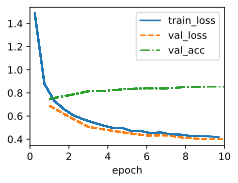

In [7]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# DropoutMLPScratch Agrupado

acc: 0.79


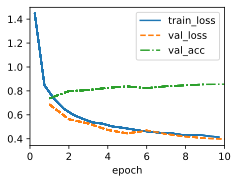

In [12]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# ------------------------------------------------------------------------------------


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)      # Se p = 1, ou seja, 100% de probabilidade de abandono, todas as unidades h serão zeradas.
    mask = (torch.rand(X.shape) > dropout).float()   # mask aplica distribuição uniform (torch.rand()) aleatória para determinar quais unidades serão zerdas.
                                                     # Mantém apenas os nós para os quais a amostra correspondente é maior que p.

    return mask * X / (1.0 - dropout)                # As unidades não zerdas serão alteradas desta forma h' = h/(1-p).



class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)



hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLPScratch(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                          # DropoutMLPScratch precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)

data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


# ------------------------------------------------------------------------------------
y_hat = model(data.val.data.type(torch.float32)) 
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')

# Memória e Gráfico

In [13]:
from torchsummary import summary



hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLPScratch(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                          # DropoutMLPScratch precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)

summary(model, input_size=(1,28*28), device="cpu")



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 256]          65,792
              ReLU-4                  [-1, 256]               0
            Linear-5                   [-1, 10]           2,570
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.03
Estimated Total Size (MB): 1.04
----------------------------------------------------------------


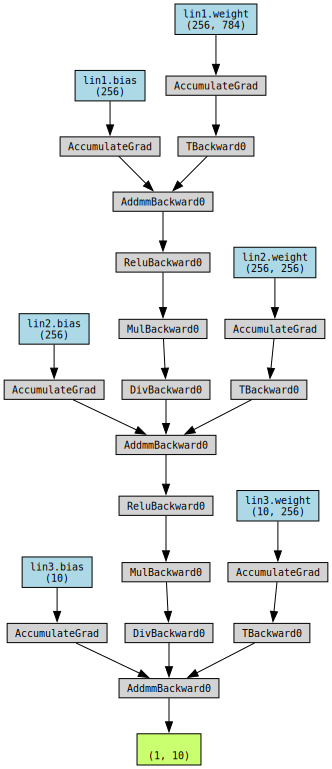

In [14]:
import sys
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import warnings
from torchviz import make_dot

import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin\\'


import d2l
import torch
from torch import nn
from d2l import torch as d2l
import graphviz.graphs

warnings.filterwarnings('ignore')



input_shape = 28 * 28

hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLPScratch(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                          # DropoutMLPScratch precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)

x = torch.randn(1, 28 * 28)
y = model(x)
make_dot(y, params=dict(model.named_parameters()))

# 5.6.3. Implementação concisa

Com APIs de alto nível, tudo o que precisamos fazer é adicionar uma Dropoutcamada após cada camada totalmente conectada, passando a probabilidade de abandono como o único argumento para seu construtor. Durante o treinamento, a Dropoutcamada eliminará aleatoriamente as saídas da camada anterior (ou equivalentemente, as entradas da camada subsequente) de acordo com a probabilidade de abandono especificada. Quando não está no modo de treinamento, a Dropoutcamada simplesmente passa os dados durante o teste.

acc: 0.82


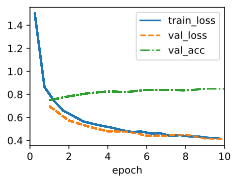

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# ------------------------------------------------------------------------------------



class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),                                                   # reshape: (28 x 28) para (1 x 784)   # Flatten = Achatar
            nn.LazyLinear(num_hiddens_1), nn.ReLU(), nn.Dropout(dropout_1), # sequência para a primeira camada
            nn.LazyLinear(num_hiddens_2), nn.ReLU(), nn.Dropout(dropout_2), # sequência para a segunda camada 
            nn.LazyLinear(num_outputs))                                     # camada de saída


hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLP(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                   # DropoutMLPS precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)


data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# ------------------------------------------------------------------------------------

y_hat = model(data.val.data.type(torch.float32))
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')



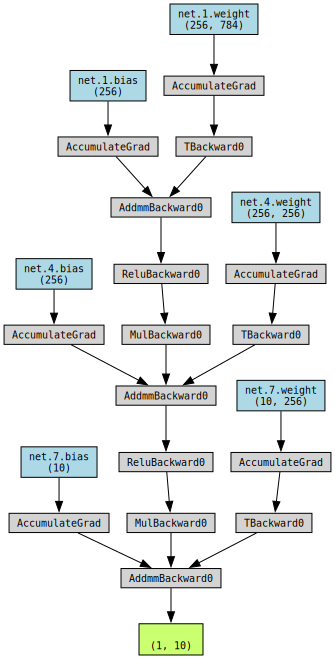

In [16]:
import sys
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import warnings
from torchviz import make_dot

import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin\\'


import d2l
import torch
from torch import nn
from d2l import torch as d2l
import graphviz.graphs

warnings.filterwarnings('ignore')



input_shape = 28 * 28

hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLP(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                          # DropoutMLPScratch precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)

x = torch.randn(1, 28 * 28)
y = model(x)
make_dot(y, params=dict(model.named_parameters()))

In [17]:
from torchsummary import summary



hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLP(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                          # DropoutMLPScratch precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)

summary(model, input_size=(1,28*28), device="cpu")



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
              ReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                   [-1, 10]           2,570
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.03
Estimated Total Size (MB): 1.05
----------------------------------------------------------------


# 5.6.4. Resumo

Além de controlar o número de dimensões e o tamanho do vetor de peso, o dropout é outra ferramenta para evitar o overfitting. Muitas vezes as ferramentas são usadas em conjunto. Observe que o dropout é usado apenas durante o treinamento: ele substitui uma ativação h
com uma variável aleatória com valor esperado.

# Exercícios

# Ex. 1. O que acontece se você alterar as probabilidades de abandono da primeira e da segunda camadas? Em particular, o que acontece se você trocar os de ambas as camadas? Projete um experimento para responder a essas perguntas, descreva seus resultados quantitativamente e resuma as conclusões qualitativas.

hparams_0 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
            'dropout_1':0.5, 'dropout_2':0.5,
           'lr':0.1}

hparams_1 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.8, 'dropout_2':0.5,
           'lr':0.1}

hparams_2 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.8,
           'lr':0.1}

hparams_3 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.8, 'dropout_2':0.8,
           'lr':0.1}

hparams_4 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':1.0, 'dropout_2':0.5,
           'lr':0.1}

hparams_5 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':1.0,
           'lr':0.1}

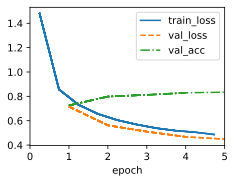

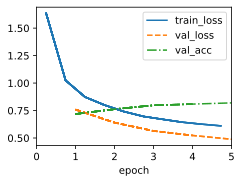

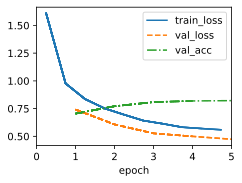

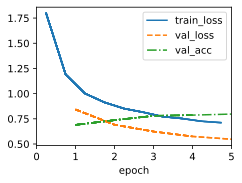

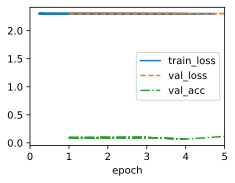

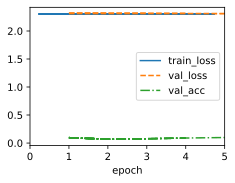

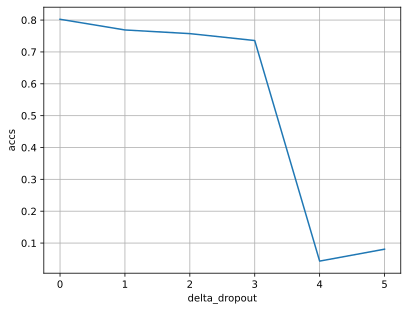

In [18]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# ------------------------------------------------------------------------------------



class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))


# ---------------------------------------------------------------------------------
hparams_0 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
            'dropout_1':0.5, 'dropout_2':0.5,
           'lr':0.1}

hparams_1 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.8, 'dropout_2':0.5,
           'lr':0.1}

hparams_2 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.8,
           'lr':0.1}

hparams_3 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.8, 'dropout_2':0.8,
           'lr':0.1}

hparams_4 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':1.0, 'dropout_2':0.5,
           'lr':0.1}

hparams_5 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':1.0,
           'lr':0.1}

# ---------------------------------------------------------------------------------
hp = [hparams_0, hparams_1, hparams_2, hparams_3, hparams_4, hparams_5]
accs = []

for hparams in hp:
    model = DropoutMLP(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                              # DropoutMLPScratch precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)
    data = d2l.FashionMNIST(batch_size=256)
    trainer = d2l.Trainer(max_epochs=5)
    trainer.fit(model, data)
    # ------------------------------------------------------------------------------------
    y_hat = model(data.val.data.type(torch.float32))
    acc = model.accuracy(y_hat,data.val.targets).item()
    accs.append(acc)

x=torch.arange(0,6)
plt.figure(7)
d2l.plot(x,accs,'delta_dropout','accs')

# Ex. 2. Aumente o número de épocas e compare os resultados obtidos ao usar o dropout com aqueles quando não o utiliza.

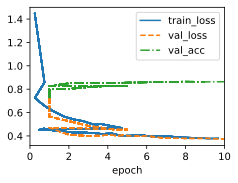

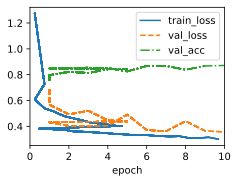

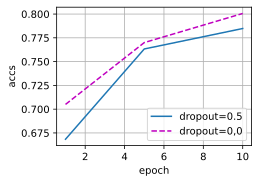

In [22]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# ------------------------------------------------------------------------------------






class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),                                                   # reshape: (28 x 28) para (1 x 784)   # Flatten = Achatar
            nn.LazyLinear(num_hiddens_1), nn.ReLU(), nn.Dropout(dropout_1), # sequência para a primeira camada
            nn.LazyLinear(num_hiddens_2), nn.ReLU(), nn.Dropout(dropout_2), # sequência para a segunda camada
            nn.LazyLinear(num_outputs))                                     # camada de saída


hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLP(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                   # DropoutMLPS precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)

accs = []    # eixo y
x = []       # eixo x - epochs
data = d2l.FashionMNIST(batch_size=256)
e = [1,5,10]
# e = [1,2,3]

for i in range(0,len(e)):
    trainer = d2l.Trainer(max_epochs=e[i])
    trainer.fit(model, data)
# ------------------------------------------------------------------------------------
    y_hat = model(data.val.data.type(torch.float32))
    acc = model.accuracy(y_hat, data.val.targets).item()
    accs.append(acc)
    x.append(e[i])


# -----------------------------------------
# -----------------------------------------
# Sem Dropout
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.0, 'dropout_2':0.0, 'lr':0.1}                       # Dicionário
model = DropoutMLP(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                   # DropoutMLPS precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)

accs1 = []    # eixo y

for i in range(0,len(e)):
    trainer = d2l.Trainer(max_epochs=e[i])
    trainer.fit(model, data)
# ------------------------------------------------------------------------------------
    y_hat = model(data.val.data.type(torch.float32))
    acc1 = model.accuracy(y_hat, data.val.targets).item()
    accs1.append(acc1)


# -----------------------------------------
# -----------------------------------------

plt.figure(3)
d2l.plot(x,[accs,accs1],'epoch','accs',legend=['dropout=0.5','dropout=0,0'])

# Ex. 3. Qual é a variação das ativações em cada camada oculta quando o dropout é ou não aplicado? Desenhe um gráfico para mostrar como essa quantidade evolui ao longo do tempo para ambos os modelos.

To summarize, dropout introduces some noise and variance to the activations in each hidden layer, which can help regularize the network and prevent overfitting. However, too much dropout can also degrade the performance and slow down the convergence. Therefore, choosing an appropriate dropout rate and weight initialization scheme is important for achieving good results.

# Ex. 4. Why is dropout not typically used at test time?

Dropout is a regularization technique commonly used during the training phase of a neural network to prevent overfitting. However, it’s not typically used at test time for a couple of important reasons.

In summary, dropout is not used at test time to maintain the deterministic and reliable nature of predictions. The main goal of dropout is to improve the generalization of the model by preventing overfitting during training. Once the model is trained, the focus shifts to making accurate and consistent predictions on new data, which dropout’s randomness can hinder.

# Ex. 5. Using the model in this section as an example, compare the effects of using dropout and weight decay. What happens when dropout and weight decay are used at the same time? Are the results additive? Are there diminished returns (or worse)? Do they cancel each other out?



Utilizando __WeightDecay__ no lugar de __Dropout__:

acc: 0.10


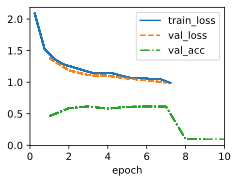

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# ------------------------------------------------------------------------------------

class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):             # wd é o lambd da implementação anterior.
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

# ------------------------------------------------------------------------------------


class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),                                                   # reshape: (28 x 28) para (1 x 784)   # Flatten = Achatar
#           nn.LazyLinear(num_hiddens_1), nn.ReLU(), nn.Dropout(dropout_1), # sequência para a primeira camada
            nn.LazyLinear(num_hiddens_1), nn.ReLU(), WeightDecay(wd=3, lr=0.01),    # sequência para a primeira camada
#           nn.LazyLinear(num_hiddens_2), nn.ReLU(), nn.Dropout(dropout_2), # sequência para a segunda camada
            nn.LazyLinear(num_hiddens_2), nn.ReLU(), WeightDecay(wd=3, lr=0.01),   # sequência para a segunda camada
            nn.LazyLinear(num_outputs))                                     # camada de saída


hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLP(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                   # DropoutMLPS precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)


data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# ------------------------------------------------------------------------------------

y_hat = model(data.val.data.type(torch.float32))
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')



Utilizando __Dropout__:

acc: 0.77


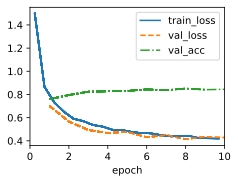

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# ------------------------------------------------------------------------------------

# class WeightDecay(d2l.LinearRegression):
#     def __init__(self, wd, lr):             # wd é o lambd da implementação anterior.
#         super().__init__(lr)
#         self.save_hyperparameters()
#         self.wd = wd

#     def configure_optimizers(self):
#         return torch.optim.SGD([
#             {'params': self.net.weight, 'weight_decay': self.wd},
#             {'params': self.net.bias}], lr=self.lr)

# ------------------------------------------------------------------------------------


class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            
            nn.Flatten(),                                                   # reshape: (28 x 28) para (1 x 784)   # Flatten = Achatar
            nn.LazyLinear(num_hiddens_1), nn.ReLU(), nn.Dropout(dropout_1), # sequência para a primeira camada
            # nn.LazyLinear(num_hiddens_1), nn.ReLU(), WeightDecay(wd=3, lr=0.01),    # sequência para a primeira camada
            nn.LazyLinear(num_hiddens_2), nn.ReLU(), nn.Dropout(dropout_2), # sequência para a segunda camada
            # nn.LazyLinear(num_hiddens_2), nn.ReLU(), WeightDecay(wd=3, lr=0.01),   # sequência para a segunda camada
            nn.LazyLinear(num_outputs))                                     # camada de saída


hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLP(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                   # DropoutMLPS precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)


data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# ------------------------------------------------------------------------------------

y_hat = model(data.val.data.type(torch.float32))
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')



Utilizando __Dropout__ seguido de __WeightDecay__:

acc: 0.10


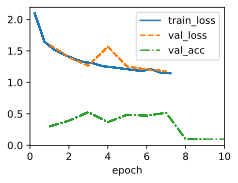

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# ------------------------------------------------------------------------------------

class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):             # wd é o lambd da implementação anterior.
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

# ------------------------------------------------------------------------------------


class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),                                                   # reshape: (28 x 28) para (1 x 784)   # Flatten = Achatar
#           nn.LazyLinear(num_hiddens_1), nn.ReLU(), nn.Dropout(dropout_1), # sequência para a primeira camada
            nn.LazyLinear(num_hiddens_1), nn.ReLU(), nn.Dropout(dropout_1), WeightDecay(wd=3, lr=0.01),    # sequência para a primeira camada
#           nn.LazyLinear(num_hiddens_2), nn.ReLU(), nn.Dropout(dropout_2), # sequência para a segunda camada
            nn.LazyLinear(num_hiddens_2), nn.ReLU(), nn.Dropout(dropout_2), WeightDecay(wd=3, lr=0.01),   # sequência para a segunda camada
            nn.LazyLinear(num_outputs))                                     # camada de saída


hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLP(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                   # DropoutMLPS precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)


data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# ------------------------------------------------------------------------------------

y_hat = model(data.val.data.type(torch.float32))
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')



Utilizando __WeightDecay__ seguido de __Dropout__:

acc: 0.20


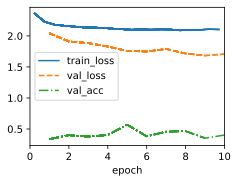

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# ------------------------------------------------------------------------------------

class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):             # wd é o lambd da implementação anterior.
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

# ------------------------------------------------------------------------------------


class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),                                                   # reshape: (28 x 28) para (1 x 784)   # Flatten = Achatar
#           nn.LazyLinear(num_hiddens_1), nn.ReLU(), nn.Dropout(dropout_1), # sequência para a primeira camada
            nn.LazyLinear(num_hiddens_1), nn.ReLU(), WeightDecay(wd=3, lr=0.01), nn.Dropout(dropout_1),    # sequência para a primeira camada
#           nn.LazyLinear(num_hiddens_2), nn.ReLU(), nn.Dropout(dropout_2), # sequência para a segunda camada
            nn.LazyLinear(num_hiddens_2), nn.ReLU(), WeightDecay(wd=3, lr=0.01), nn.Dropout(dropout_2),  # sequência para a segunda camada
            nn.LazyLinear(num_outputs))                                     # camada de saída


hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLP(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                   # DropoutMLPS precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)


data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# ------------------------------------------------------------------------------------

y_hat = model(data.val.data.type(torch.float32))
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')



# Ex. 7. Invent another technique for injecting random noise at each layer that is different from the standard dropout technique. Can you develop a method that outperforms dropout on the Fashion-MNIST dataset (for a fixed architecture)?

acc: 0.77


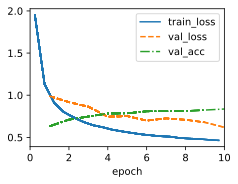

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# ------------------------------------------------------------------------------------


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return (torch.zeros_like(X))+0.1      # Se p = 1, ou seja, 100% de probabilidade de abandono, todas as unidades h serão 0.1.
    mask = (torch.rand(X.shape) > dropout).float()   # mask aplica distribuição uniform (torch.rand()) aleatória para determinar quais unidades serão zerdas.
                                                     # Mantém apenas os nós para os quais a amostra correspondente é maior que p.

    return mask * X / (1.0 - (dropout/2))                # As unidades não zerdas serão alteradas desta forma h' = h/(1-(p/2)).



class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)



hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}                       # Dicionário
model = DropoutMLPScratch(**hparams)      # **kwargs.  kwargs é sempre um dicionário com quantidade de parâmetros variável
                                          # DropoutMLPScratch precisa de 6 argumentos, mas só foi dado hparams pois ele é do formato **kwargs (qtd de parâmetros variável)

data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


# ------------------------------------------------------------------------------------

y_hat = model(data.val.data.type(torch.float32))
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')

# Outras respostas:

https://pandalab.me/archives/dropout